# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

In [2]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

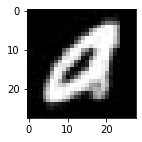

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

In [5]:
import os, sys, time, math, gc

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import uuid

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
# Сырые данные

path = "./images/train"
train_images = []
train_labels = []
for directory in tqdm(os.listdir(path)):
    for i, image in enumerate(os.listdir(path + "/" + directory), 0):
        train_images.append(plt.imread(path + "/" + directory + "/" + image))
        train_labels.append(directory)

path = "./images/test"
test_images = []
test_labels = []
for directory in tqdm(os.listdir(path)):
    for i, image in enumerate(os.listdir(path + "/" + directory), 0):
        test_images.append(plt.imread(path + "/" + directory + "/" + image))
        test_labels.append(directory)

100%|██████████| 26/26 [00:03<00:00,  7.96it/s]


In [8]:
# Предобработка данных

class Pictures(torch.utils.data.Dataset):
    def __init__(self, x, y, channels=3, CHW=True, transposed=False):
        self.x = Pictures.to_numpy(x)
        self.y = Pictures.to_numpy(y)
        self.channels = channels
        self.CHW = CHW
        self.transposed = transposed

    def __len__(self):
        return len(self.x)

    @staticmethod
    def to_numpy(image):
        if type(image) == torch.Tensor:
            return image.cpu().detach().numpy()
        elif type(image) == list:
            return np.array(image)
        else:
            return image

    @staticmethod
    def update(image: np.array, new_channels=None, normal=False, in_CHW=False, out_CHW=False):

        channels = None
        height = None
        width = None
        if in_CHW:
            channels = image.shape[0]
            height = image.shape[1]
            width = image.shape[2]
        else:
            channels = image.shape[2]
            height = image.shape[0]
            width = image.shape[1]

        new_shape = None
        if out_CHW:
            new_shape = (new_channels if new_channels is not None else channels, height, width)
        else:
            new_shape = (height, width, new_channels if new_channels is not None else channels)
        updated_image = np.zeros(new_shape, dtype=float if normal else int)

        for i in range(height):
            for j in range(width):
                value = None
                if in_CHW:
                    value = image[0][i][j]
                else:
                    value = image[i][j][0]

                if normal:
                    value = value / 255
                else:
                    value = value * 255

                for k in range(new_channels if new_channels is not None else channels):
                    if out_CHW:
                        updated_image[k][i][j] = value
                    else:
                        updated_image[i][j][k] = value

        return updated_image


    def __getitem__(self, idx):
        image = self.x[idx]
        if not self.transposed:
            image = np.transpose(image, axes=(1, 0, 2))
        image = Pictures.update(image, new_channels=self.channels, normal=True, in_CHW=False, out_CHW=self.CHW)
        image = torch.from_numpy(image)
        image = image.to(torch.float32)
        image = image.to(device)

        label = self.y[idx]
        label = ord(label) - 97
        label = torch.tensor(label)
        label = label.to(device)

        return {"Image": image, "Label": label}


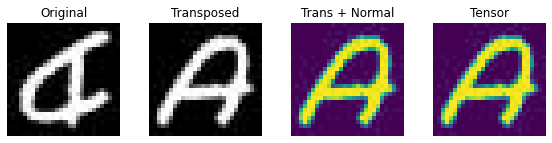

In [9]:
def draw_images(images):
    columns = 5
    rows = int(len(images) / columns) + 1
    fig = plt.figure(figsize=(10, 2*rows))
    for i, (label, image) in enumerate(images, 1):
        subplot = fig.add_subplot(rows, columns, i)
        subplot.axis("off")
        if type(image) == np.ndarray:
            subplot.imshow(image)
        elif type(image) == torch.Tensor:
            subplot.imshow(image.cpu().detach().numpy()[0])
        if type(label) == str:
            subplot.set_title(label)
        elif type(label) == torch.Tensor:
            subplot.set_title(chr(label.item() + 65))

    plt.tight_layout()
    plt.show()

picture = Pictures(train_images, train_labels)[1]["Image"]
draw_images([
              ("Original", train_images[1]),
              ("Transposed", Pictures.update(picture, new_channels=3, normal=False, in_CHW=True, out_CHW=False)),
              ("Trans + Normal", Pictures.update(picture, new_channels=1, normal=True, in_CHW=True, out_CHW=False)),
              ("Tensor", picture)
            ])

In [10]:
def draw_statistics(parameters, train_accuracy, test_accuracy):
    fig = plt.figure(figsize=(16, 16))

    # Bar chart
    for k, accuracy in enumerate([train_accuracy, test_accuracy], 1):
        subplot = fig.add_subplot(2, 1, k)
        subplot.set_title("Train" if k == 1 else "Prediction", size=15)
        epochs = len(accuracy[0])
        bar_width = 1/epochs - 0.1
        for epoch in range(-(epochs//2), (epochs//2 + 1)):
            positions = [i+(epoch*bar_width) for i in range(len(accuracy))]
            values = [accuracy[i][epoch+(epochs//2)] for i in range(len(accuracy))]
            plt.bar(positions, values, width=bar_width)
        plt.xticks([i for i in range(len(accuracy))], labels=[f"#{i}" for i in range(1, len(accuracy) + 1)])
        plt.xlabel("Model variant")
        plt.ylabel("Average accuracy")
        plt.grid(axis='y', color = 'grey', linestyle = '--')
        plt.legend([f"Epoch #{i}" for i in range(1,  epochs + 1)])

    # Table
    table_values = []
    for param in range(len(parameters[0])):
        table_values.append([parameters[column][param][1] for column in range(len(parameters))])
    table_column_labels = [f"#{i}" for i in range(1, len(accuracy) + 1)]
    table_row_labels = [label for (label, value) in parameters[0]]
    plt.table(table_values,
              colLabels=table_column_labels,
              rowLabels=table_row_labels,
              loc='bottom',
              bbox=[0, -0.4, 1, 0.25])

    plt.show()

In [11]:
def train(dataloader, model, loss_criteria, optimizer, limit=-1, progress=False):
    model.to(device)
    model.train()  # Enable training mode

    # Metrics
    batches_count = 0
    all_losses = []
    all_acc = []
    total_loss = 0
    total_acc = 0

    with tqdm(total=len(dataloader), position=0, leave=progress) as pbar:
        if not progress:
            pbar.close()

        for i, batch in enumerate(dataloader, 0):
            images = batch["Image"].to(device)
            labels = batch["Label"].to(device)

            # Compute prediction
            pred = model(images)
            loss = loss_criteria(pred, labels)
            acc = (pred.argmax(1) == labels).float().mean()

            # Update weights (backpropagation)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update metrics
            all_losses.append(loss.item())
            all_acc.append(acc.item())
            total_loss += loss.item()
            total_acc += acc.item()
            batches_count += 1

            # Update progress bar
            if progress:
                pbar.clear()
                pbar.set_description(
                    f"Training   | "
                    f"Loss (cur): {round(loss.item(), 2)} | "
                    f"Loss (avg): {round(total_loss / batches_count, 2)} | "
                    f"Acc (cur): {round(acc.item() * 100, 2)}% | "
                    f"Acc (avg): {round(total_acc / batches_count * 100, 2)}% "
                )
                pbar.update(1)

            if 0 < limit < i:
                break

    return all_acc, all_losses

In [12]:
def test(dataloader, model, loss_criteria, limit=-1, progress=False):
    model.to(device)
    model.eval()  # Enable prediction mode

    # Metrics
    batches_count = 0
    all_losses = []
    all_acc = []
    all_labels = []
    all_pred = []
    total_loss = 0
    total_acc = 0


    with tqdm(total=len(dataloader), position=0, leave=progress) as pbar:
        if not progress:
            pbar.close()

        with torch.no_grad():
            for i, batch in enumerate(dataloader, 0):
                images = batch["Image"].to(device)
                labels = batch["Label"].to(device)

                # Compute prediction
                pred = model(images)
                loss = loss_criteria(pred, labels)
                accuracy = (pred.argmax(1) == labels).float().mean()

                # Update metrics
                all_losses.append(loss.item())
                all_acc.append(accuracy.item())
                all_labels.extend(labels.cpu().detach().numpy())
                all_pred.extend(pred.argmax(1).cpu().detach().numpy())
                total_loss += loss.item()
                total_acc += accuracy.item()
                batches_count += 1

                # Update progress bar
                if progress:
                    pbar.set_description(
                        f"Validation | "
                        f"Loss (cur): {round(loss.item(), 2)} | "
                        f"Loss (avg): {round(total_loss / batches_count, 2)} | "
                        f"Acc (cur): {round(accuracy.item() * 100, 2)}% | "
                        f"Acc (avg): {round(total_acc / batches_count * 100, 2)}% "
                    )
                    pbar.update(1)

                if 0 < limit < i:
                    break

        return all_acc, all_losses, all_labels, all_pred

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.

In [13]:
class Net(nn.Module):
    name = ""

    def __init__(self, neurons, name=""):
        super(Net, self).__init__()
        self.name = name
        self.num = neurons

        self.input_layer = nn.Sequential(
            nn.Linear(784, neurons),
            nn.ReLU()
            ).to(device)

        self.model = nn.Sequential(
            ).to(device)

        self.output_layer = nn.Sequential(
            nn.Linear(neurons, 26),
            ).to(device)

    def add_dense_layer(self):
        self.model.add_module(f"{uuid.uuid4()}", nn.Linear(self.num, self.num))
        self.model.add_module(f"{uuid.uuid4()}", nn.ReLU())

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.input_layer(x)
        x = self.model(x)
        x = self.output_layer(x)
        return x

layers: 3 | lr: 0.0005 | neurons: 1024 | batch: 1024: 100%|██████████| 72/72 [3:25:41<00:00, 171.41s/it]  


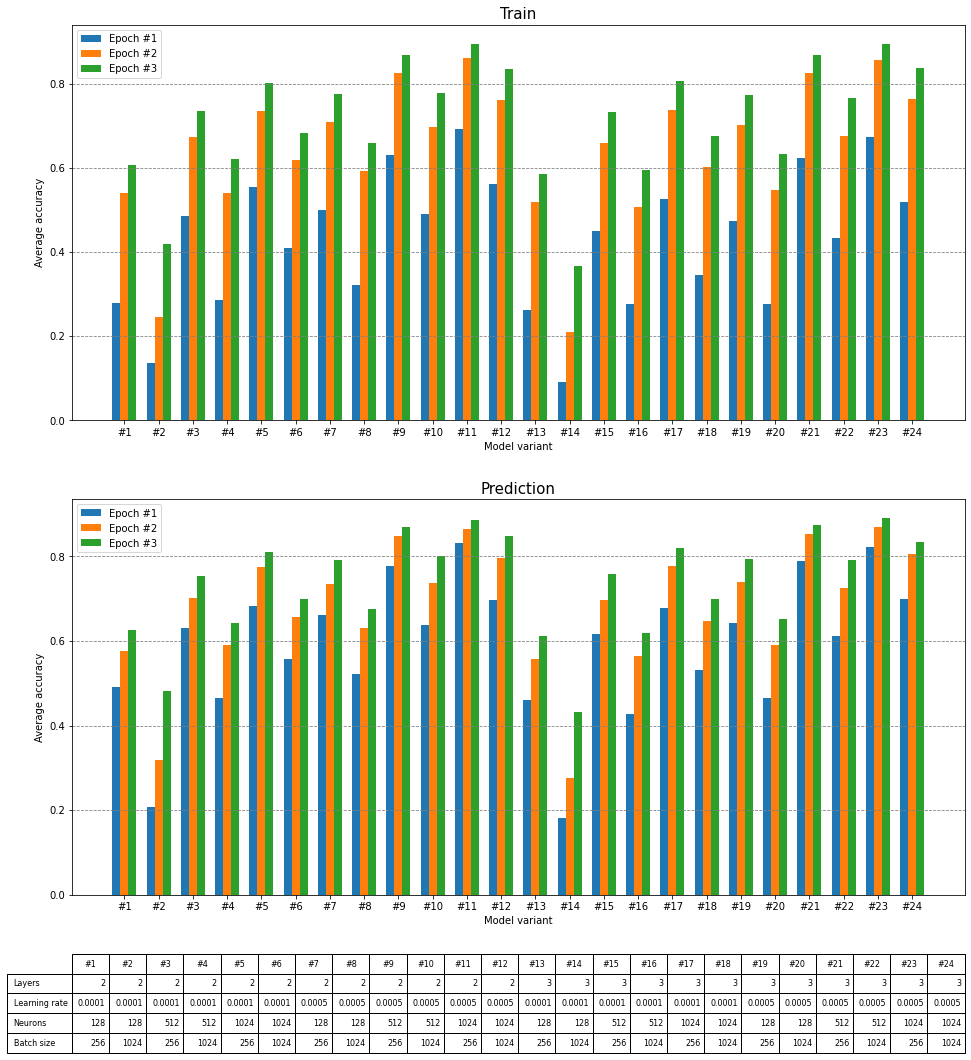

In [14]:
# Исследуем реалистичные граничные значения, иначе исследование может затянуться...
# Количество вариантов: (lr * batch * neurons * layers) = 2 * 2 * 3 * 2 = 24
# Для каждого варианта сетки делается проход в три эпохи
# Используемый оптимайзер: AdamW
# Исользуемый loss: CrossEntropyLoss

learning_rate_arr = [0.0001, 0.0005]
batch_size_arr = [256, 1024]
neurons_num_arr = [128, 512, 1024]
layers_count_arr = [2, 3]
epoch_count = 3

parameters = []
train_accuracy = []
test_accuracy = []

train_data = Pictures(train_images, train_labels, channels=1, CHW=True)
test_data = Pictures(test_images, test_labels, channels=1, CHW=True)

count = len(learning_rate_arr)\
        *len(batch_size_arr)\
        *len(neurons_num_arr)\
        *len(layers_count_arr)
with tqdm(total=count * epoch_count, position=0, leave=True) as pbar:
    for layers_count in layers_count_arr:
        for learning_rate in learning_rate_arr:
            for neurons_num in neurons_num_arr:
                for batch_size in batch_size_arr:

                    torch.cuda.empty_cache()
                    gc.collect()

                    ######################################################
                    # Инициализация

                    net = Net(neurons_num, f"{layers_count} dense layers")
                    for i in range(layers_count):
                        net.add_dense_layer()
                    optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
                    loss_criterion = nn.CrossEntropyLoss()

                    ######################################################
                    # Эпохи

                    train_accuracy_epochs = []
                    test_accuracy_epochs = []
                    for epoch in range(epoch_count):

                        # Обучение
                        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                        train_accuracy_arr, _ = train(train_dataloader, net, loss_criterion, optimizer)
                        train_accuracy_epochs.append(sum(train_accuracy_arr)/len(train_accuracy_arr))

                        # Предсказание
                        test_dataloader = DataLoader(test_data, batch_size=batch_size)
                        test_accuracy_arr, _, _, _ = test(test_dataloader, net, loss_criterion)
                        test_accuracy_epochs.append(sum(test_accuracy_arr)/len(test_accuracy_arr))

                        pbar.set_description(f"layers: {layers_count} | lr: {learning_rate} | neurons: {neurons_num} | batch: {batch_size}")
                        pbar.update(1)

                    del net, train_dataloader, test_dataloader
                    gc.collect()
                    torch.cuda.empty_cache()

                    ######################################################
                    # Обновление статистики

                    parameters.append([
                        ("Layers", layers_count),
                        ("Learning rate", learning_rate),
                        ("Neurons", neurons_num),
                        ("Batch size", batch_size)
                    ])
                    train_accuracy.append(train_accuracy_epochs)
                    test_accuracy.append(test_accuracy_epochs)

draw_statistics(parameters, train_accuracy, test_accuracy)



2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.

In [18]:
# Лучшие результаты у моделей #11 и #23
layers = 3
learning_rate = 0.0005
neurons = 1024
batch_size = 256

# Инициализация
best_dense_net = Net(neurons)
for i in range(layers):
    best_dense_net.add_dense_layer()
optimizer = torch.optim.AdamW(best_dense_net.parameters(), lr=learning_rate)
loss_criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
gc.collect()

for epoch in range(10):
    print(f"--- Epoch #{epoch + 1} ---")
    # Обучение
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    _, _ = train(train_dataloader, best_dense_net, loss_criterion, optimizer, progress=True)
    # Предсказание
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    _, _, labels, pred = test(test_dataloader, best_dense_net, loss_criterion, progress=True)

--- Epoch #1 ---


Training   | Loss (cur): 0.46 | Loss (avg): 1.05 | Acc (cur): 84.48% | Acc (avg): 68.07% : 100%|██████████| 254/254 [02:43<00:00,  1.55it/s]
Validation | Loss (cur): 0.39 | Loss (avg): 0.53 | Acc (cur): 88.0% | Acc (avg): 83.32% : 100%|██████████| 51/51 [00:31<00:00,  1.64it/s] 


--- Epoch #2 ---


Training   | Loss (cur): 0.49 | Loss (avg): 0.43 | Acc (cur): 87.07% | Acc (avg): 86.05% : 100%|██████████| 254/254 [02:43<00:00,  1.55it/s]
Validation | Loss (cur): 0.28 | Loss (avg): 0.39 | Acc (cur): 93.5% | Acc (avg): 87.34% : 100%|██████████| 51/51 [00:32<00:00,  1.59it/s] 


--- Epoch #3 ---


Training   | Loss (cur): 0.29 | Loss (avg): 0.32 | Acc (cur): 90.52% | Acc (avg): 89.53% : 100%|██████████| 254/254 [02:44<00:00,  1.55it/s]
Validation | Loss (cur): 0.37 | Loss (avg): 0.34 | Acc (cur): 90.0% | Acc (avg): 88.9% : 100%|██████████| 51/51 [00:30<00:00,  1.66it/s]  


--- Epoch #4 ---


Training   | Loss (cur): 0.22 | Loss (avg): 0.26 | Acc (cur): 90.52% | Acc (avg): 91.36% : 100%|██████████| 254/254 [02:43<00:00,  1.55it/s]
Validation | Loss (cur): 0.26 | Loss (avg): 0.33 | Acc (cur): 93.0% | Acc (avg): 89.25% : 100%|██████████| 51/51 [00:30<00:00,  1.66it/s] 


--- Epoch #5 ---


Training   | Loss (cur): 0.2 | Loss (avg): 0.22 | Acc (cur): 92.67% | Acc (avg): 92.34% : 100%|██████████| 254/254 [02:43<00:00,  1.55it/s] 
Validation | Loss (cur): 0.33 | Loss (avg): 0.32 | Acc (cur): 92.5% | Acc (avg): 89.78% : 100%|██████████| 51/51 [00:30<00:00,  1.65it/s] 


--- Epoch #6 ---


Training   | Loss (cur): 0.17 | Loss (avg): 0.19 | Acc (cur): 94.4% | Acc (avg): 93.27% : 100%|██████████| 254/254 [02:43<00:00,  1.55it/s] 
Validation | Loss (cur): 0.32 | Loss (avg): 0.3 | Acc (cur): 91.0% | Acc (avg): 90.13% : 100%|██████████| 51/51 [00:32<00:00,  1.59it/s]  


--- Epoch #7 ---


Training   | Loss (cur): 0.2 | Loss (avg): 0.17 | Acc (cur): 93.97% | Acc (avg): 93.89% : 100%|██████████| 254/254 [02:34<00:00,  1.65it/s] 
Validation | Loss (cur): 0.32 | Loss (avg): 0.31 | Acc (cur): 91.5% | Acc (avg): 90.36% : 100%|██████████| 51/51 [00:31<00:00,  1.62it/s] 


--- Epoch #8 ---


Training   | Loss (cur): 0.11 | Loss (avg): 0.15 | Acc (cur): 96.98% | Acc (avg): 94.55% : 100%|██████████| 254/254 [02:43<00:00,  1.55it/s]
Validation | Loss (cur): 0.28 | Loss (avg): 0.29 | Acc (cur): 92.0% | Acc (avg): 90.89% : 100%|██████████| 51/51 [00:32<00:00,  1.56it/s] 


--- Epoch #9 ---


Training   | Loss (cur): 0.23 | Loss (avg): 0.13 | Acc (cur): 93.97% | Acc (avg): 95.15% : 100%|██████████| 254/254 [02:43<00:00,  1.55it/s]
Validation | Loss (cur): 0.34 | Loss (avg): 0.32 | Acc (cur): 92.5% | Acc (avg): 90.59% : 100%|██████████| 51/51 [00:30<00:00,  1.66it/s] 


--- Epoch #10 ---


Training   | Loss (cur): 0.09 | Loss (avg): 0.12 | Acc (cur): 96.55% | Acc (avg): 95.4% : 100%|██████████| 254/254 [02:42<00:00,  1.57it/s] 
Validation | Loss (cur): 0.3 | Loss (avg): 0.32 | Acc (cur): 94.5% | Acc (avg): 90.65% : 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]  


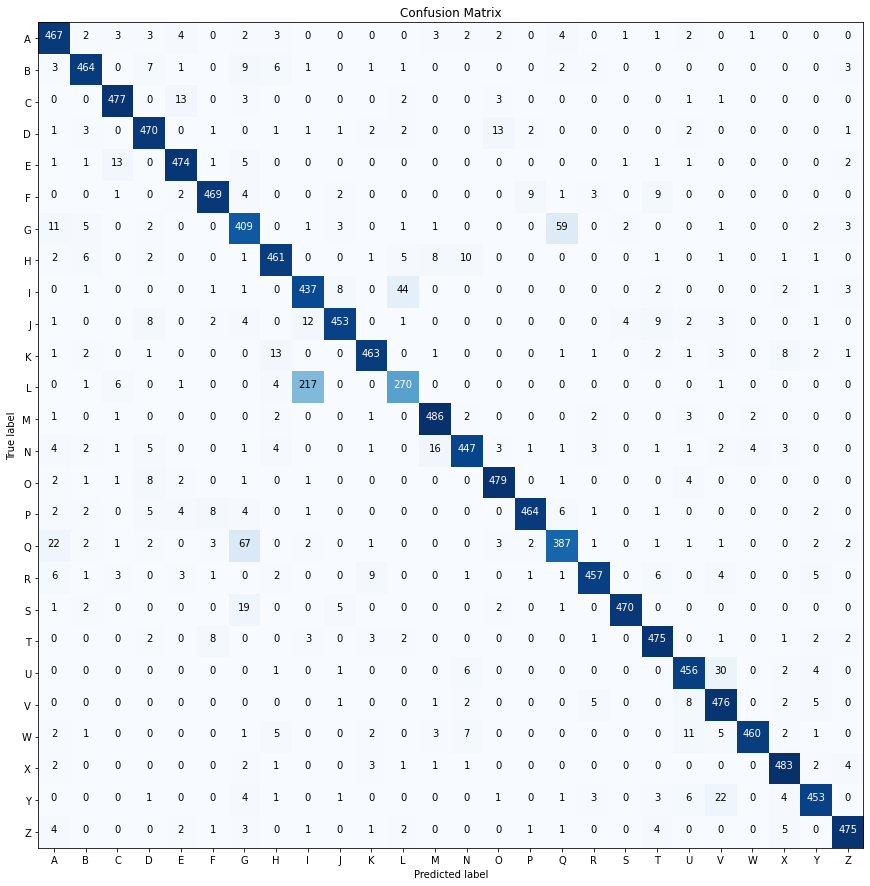

In [23]:
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, pred)

plt.figure(figsize=(12, 12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(range(26), [chr(i+65) for i in range(26)])
plt.yticks(range(26), [chr(i+65) for i in range(26)])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.0f'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


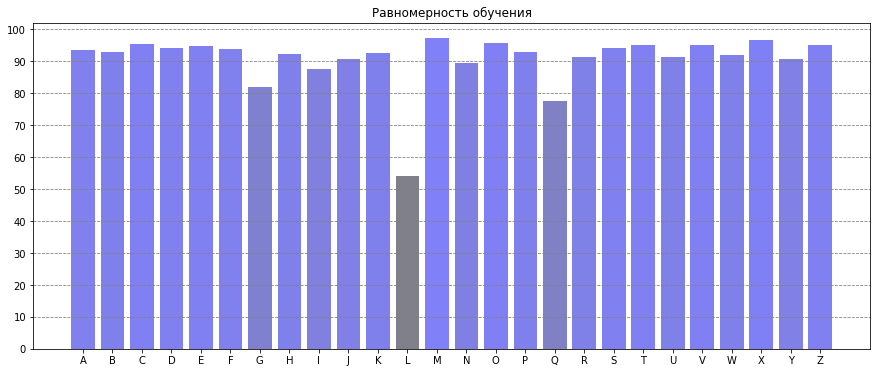

Буква с самой высокой точность: M - 97.2%
Буква с самой низкой точность: L - 54.0%


In [24]:
letters = [cm[i][i] for i in range(26)]

plt.figure(figsize=(15, 6))
plt.bar(range(26), [cm[i][i] / 500 * 100 for i in range(26)], color=[(0.5,0.5,letters[i]/500) for i in range(len(letters))])
plt.yticks(range(0, 101, 10))
plt.xticks(range(26), [chr(i + 65) for i in range(26)])
plt.grid(axis='y', color = 'grey', linestyle = '--')
plt.title("Равномерность обучения")
plt.show()

index_max = max(range(len(letters)), key=letters.__getitem__)
index_min = min(range(len(letters)), key=letters.__getitem__)

print(f"Буква с самой высокой точность: {chr(index_max + 65)} - {round(letters[index_max] / 500 * 100, 2)}%")
print(f"Буква с самой низкой точность: {chr(index_min + 65)} - {round(letters[index_min] / 500 * 100, 2)}%")

3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.


Top 10:
L <-- I (217 times)
Q <-- G (67 times)
G <-- Q (59 times)
I <-- L (44 times)
U <-- V (30 times)
Y <-- V (22 times)
S <-- G (19 times)
N <-- M (16 times)
C <-- E (13 times)
D <-- O (13 times)

'L' и 'I' путаются, так как одинаковы в нижнем регистре
'Q' и 'G' путаются, когда хвост недорисован/перерисован
'J' и 'D' путаются, так как одинаковы в нижнем регистре
'O' и 'D' путаются, когда буква под наклоном


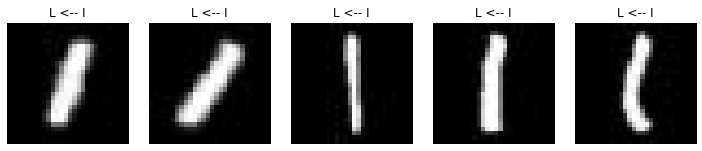

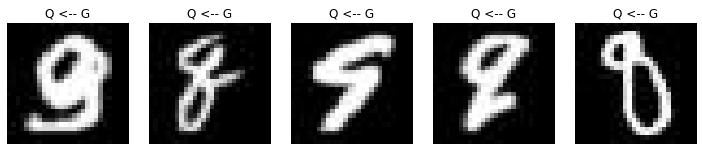

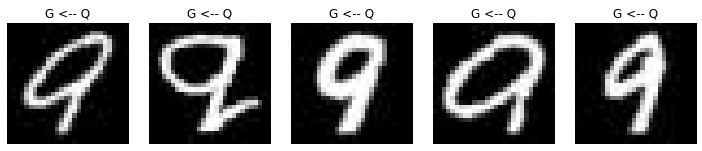

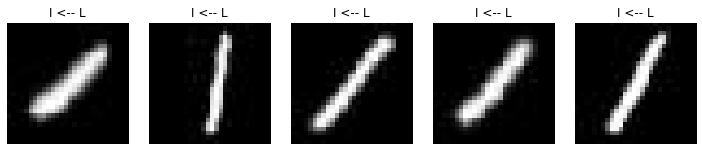

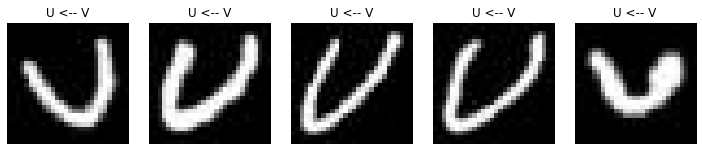

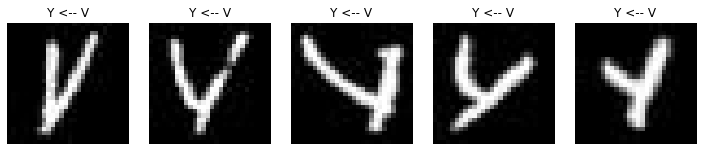

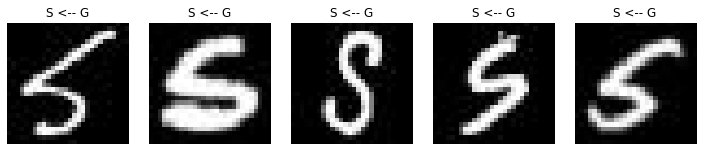

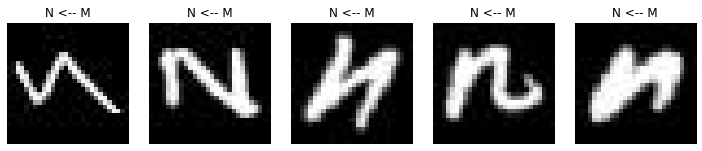

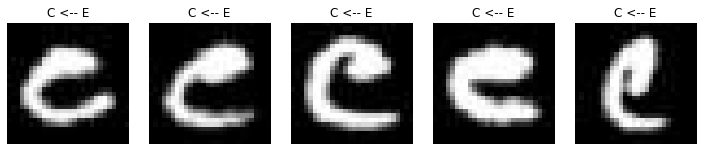

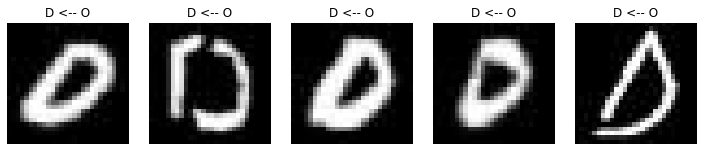

In [25]:
confusions = []
for letter_class in range(26):
    confusions_letter = []
    most_confuse = sorted(range(len(cm[letter_class])), key=cm[letter_class].__getitem__, reverse=True)[1]
    for i in range(500):
        index = letter_class*500+i
        if labels[index] != pred[index] and pred[index] == most_confuse:
            confusions_letter.append((index, labels[index], pred[index]))
    confusions.append(confusions_letter)
confusions = sorted(confusions, key=lambda x: len(x), reverse=True)

print("Top 10:")
for i in range(10):
    true_letter = chr(confusions[i][0][1]+65)
    confuse_letter = chr(confusions[i][0][2]+65)
    confuse_count = cm[confusions[i][0][1]][confusions[i][0][2]]
    print(f"{true_letter} <-- {confuse_letter} ({confuse_count} times)")

print()
print("'L' и 'I' путаются, так как одинаковы в нижнем регистре")
print("'Q' и 'G' путаются, когда хвост недорисован/перерисован")
print("'J' и 'D' путаются, так как одинаковы в нижнем регистре")
print("'O' и 'D' путаются, когда буква под наклоном")

for i in range(10):
    true_letter = chr(confusions[i][0][1]+65)
    confuse_letter = chr(confusions[i][0][2]+65)
    draw_images([
        (f"{true_letter} <-- {confuse_letter}", Pictures.update(test_data[confusions[i][j][0]]["Image"], new_channels=3, normal=False, in_CHW=True, out_CHW=False))
            for j in range(min(5, confuse_count))
    ])

4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?

Точность буквы 'T' - 95.0%
T <-- F (8 times)
T <-- I (3 times)
T <-- K (3 times)
T <-- D (2 times)
T <-- L (2 times)
T <-- Y (2 times)
T <-- Z (2 times)
T <-- R (1 times)
T <-- V (1 times)


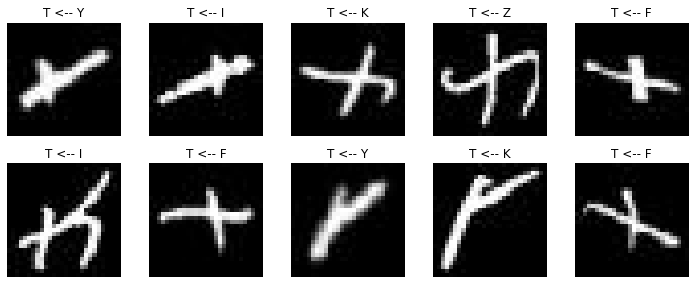

In [33]:
letter = "T" # Trukhin
letter_class = ord(letter) - 65
print(f"Точность буквы '{letter}' - {round(cm[letter_class][letter_class] / 500 * 100, 2)}%")

confusions = []
for i in range(500):
    index = letter_class*500+i
    if labels[index] != pred[index]:
        confusions.append((index, labels[index], pred[index]))

for confuse_letter, confuse_count in sorted([(i, cm[letter_class][i]) for i in range(26)], key=lambda x: x[1], reverse=True)[1:10]:
    confuse_letter = chr(confuse_letter + 65)
    print(f"{letter} <-- {confuse_letter} ({confuse_count} times)")

draw_images([
    (f"{chr(confusions[i][1] + 65)} <-- {chr(confusions[i][2] + 65)}", test_images[confusions[i][0]])
        for i in range(min(10, len(confusions)))
])

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.


In [13]:
class ConvNet(nn.Module):
    name = ""

    def __init__(self, name=""):
        super(ConvNet, self).__init__()
        self.name = name
        self.sizes = [(1, 28, 28)]

        self.conv_layers = nn.Sequential(
        ).to(device)

        self.input_layer = nn.Sequential(
        ).to(device)

        self.linear_layers = nn.Sequential(
        ).to(device)

        self.output_layer = nn.Sequential(
            nn.Linear(256, 26),
        ).to(device)


    def add_conv_layer(self, channels, kernel_size=2, stride=1, padding=0, with_batch_norm=False, with_group_norm=False):
        self.conv_layers.add_module(f"{uuid.uuid4()}", nn.Conv2d(self.sizes[-1][0], channels, kernel_size, stride=stride, padding=padding, device=device))
        if with_batch_norm:
            self.conv_layers.add_module(f"{uuid.uuid4()}", nn.LazyBatchNorm2d())
        if with_group_norm:
            self.conv_layers.add_module(f"{uuid.uuid4()}", nn.GroupNorm(max(1, channels), channels, device=device))
        self.conv_layers.add_module(f"{uuid.uuid4()}", nn.ReLU())

        h = math.floor((self.sizes[-1][1] + 2 * padding - 1 * (kernel_size - 1) - 1)/stride + 1)
        w = math.floor((self.sizes[-1][2] + 2 * padding - 1 * (kernel_size - 1) - 1)/stride + 1)

        self.sizes.append((channels, h, w))
        self.update_input_layer(channels * h * w, with_batch_norm)


    def add_linear_layer(self, neurons_in, neurons_out, with_batch_norm=False):
        self.linear_layers.add_module(f"{uuid.uuid4()}", nn.Linear(neurons_in, neurons_out, device=device))
        if with_batch_norm:
            self.linear_layers.add_module(f"{uuid.uuid4()}", nn.LazyBatchNorm1d())
        self.linear_layers.add_module(f"{uuid.uuid4()}", nn.ReLU())

        self.update_output_layer(neurons_out)


    def update_output_layer(self, neurons):
        del self.output_layer
        self.output_layer = nn.Sequential().to(device)
        self.output_layer.add_module(f"{uuid.uuid4()}", nn.Linear(neurons, 26, device=device))


    def update_input_layer(self, neurons, with_batch_norm=False):
        del self.input_layer
        self.input_layer = nn.Sequential().to(device)
        self.input_layer.add_module(f"{uuid.uuid4()}", nn.Linear(neurons, 2048, device=device))
        if with_batch_norm:
            self.linear_layers.add_module(f"{uuid.uuid4()}", nn.LazyBatchNorm1d())
        self.input_layer.add_module(f"{uuid.uuid4()}", nn.ReLU())


    def forward(self, x):
        x = self.conv_layers(x)
        x = nn.Flatten()(x)
        x = self.input_layer(x)
        x = self.linear_layers(x)
        x = self.output_layer(x)
        return x

layers: 3 | ker: 3 | chn: 12 | Stride: 3: 100%|██████████| 48/48 [30:13<00:00, 37.78s/it]


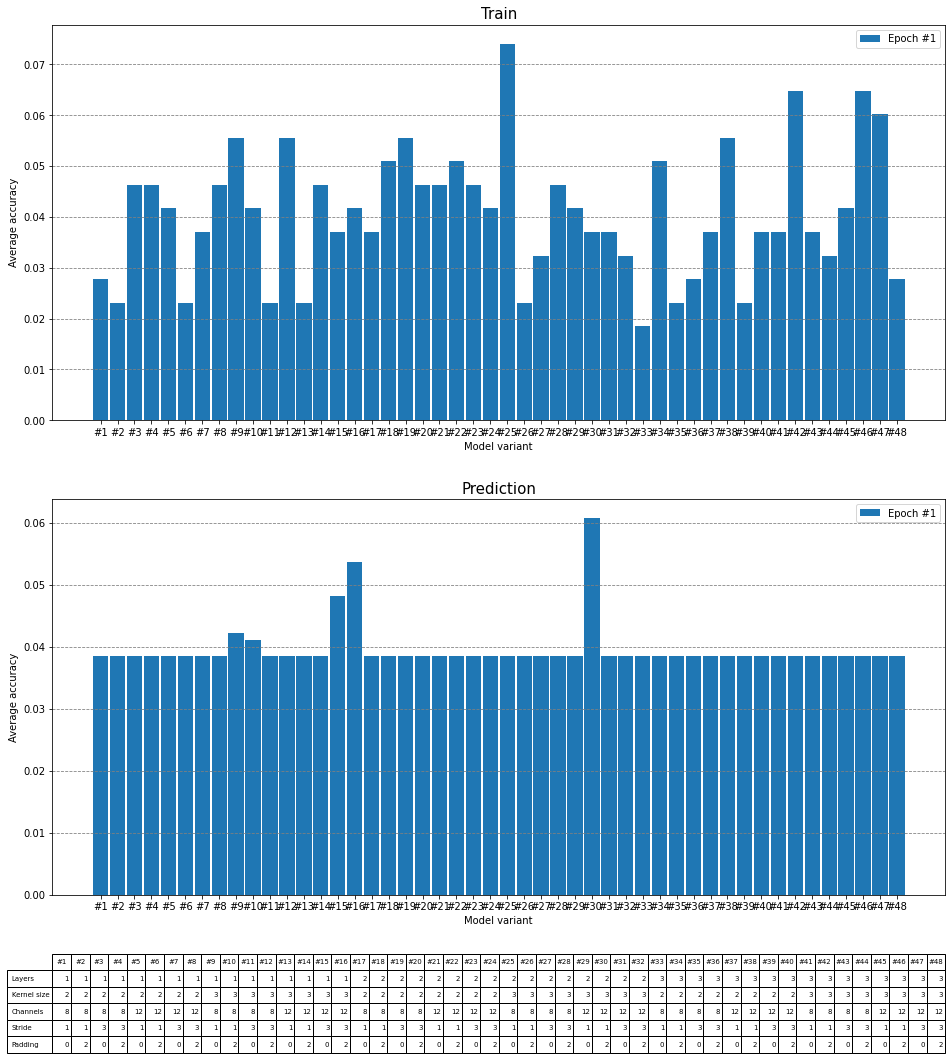

In [17]:
layers_count_arr = [1, 2, 3]
kernel_size_arr = [2, 3]
channels_arr = [8, 12]
stride_arr = [1, 3]
padding_arr = [0, 2]

batch_size = 8
epoch_count = 1

parameters = []
train_accuracy = []
test_accuracy = []

train_data = Pictures(train_images, train_labels, channels=1, CHW=True)
test_data = Pictures(test_images, test_labels, channels=1, CHW=True)

count = len(layers_count_arr)\
        *len(kernel_size_arr)\
        *len(channels_arr)\
        *len(stride_arr)\
        *len(padding_arr)

with tqdm(total=count * epoch_count, position=0, leave=True) as pbar:
    for layers_count in layers_count_arr:
        for kernel_size in kernel_size_arr:
            for channels in channels_arr:
                for stride in stride_arr:
                    for padding in padding_arr:

                        ######################################################
                        # Инициализация

                        net = ConvNet()
                        net.add_linear_layer(2048, 1024)
                        net.add_linear_layer(1024, 512)
                        net.add_linear_layer(512, 256)
                        for i in range(layers_count):
                            net.add_conv_layer(channels, kernel_size, stride=stride, padding=padding)
                        optimizer = torch.optim.AdamW(net.parameters(), lr=0.0005)
                        loss_criterion = nn.CrossEntropyLoss()

                        ######################################################
                        # Эпохи

                        train_accuracy_epochs = []
                        test_accuracy_epochs = []
                        for epoch in range(epoch_count):

                            # Обучение
                            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                            train_accuracy_arr, _ = train(train_dataloader, net, loss_criterion, optimizer, limit=25)
                            train_accuracy_epochs.append(sum(train_accuracy_arr)/len(train_accuracy_arr))

                            # Предсказание
                            test_dataloader = DataLoader(test_data, batch_size=batch_size)
                            test_accuracy_arr, _, _, _ = test(test_dataloader, net, loss_criterion)
                            test_accuracy_epochs.append(sum(test_accuracy_arr)/len(test_accuracy_arr))

                            pbar.set_description(f"layers: {layers_count} | ker: {kernel_size} | chn: {channels} | Stride: {stride}")
                            pbar.update(1)

                            del train_dataloader, test_dataloader
                            gc.collect()
                            torch.cuda.empty_cache()

                        del net
                        gc.collect()
                        torch.cuda.empty_cache()

                        ######################################################
                        # Обновление статистики

                        parameters.append([
                            ("Layers", layers_count),
                            ("Kernel size", kernel_size),
                            ("Channels", channels),
                            ("Stride", stride),
                            ("Padding", padding)
                        ])
                        train_accuracy.append(train_accuracy_epochs)
                        test_accuracy.append(test_accuracy_epochs)

draw_statistics(parameters, train_accuracy, test_accuracy)


2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.

batch: False | group: True | epoch: 2 :  17%|█▋        | 6/36 [04:00<19:39, 39.33s/it] D:\Program Files\Python\venvs\torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
batch: True | group: True | epoch: 2 : 100%|██████████| 36/36 [30:20<00:00, 50.58s/it]  


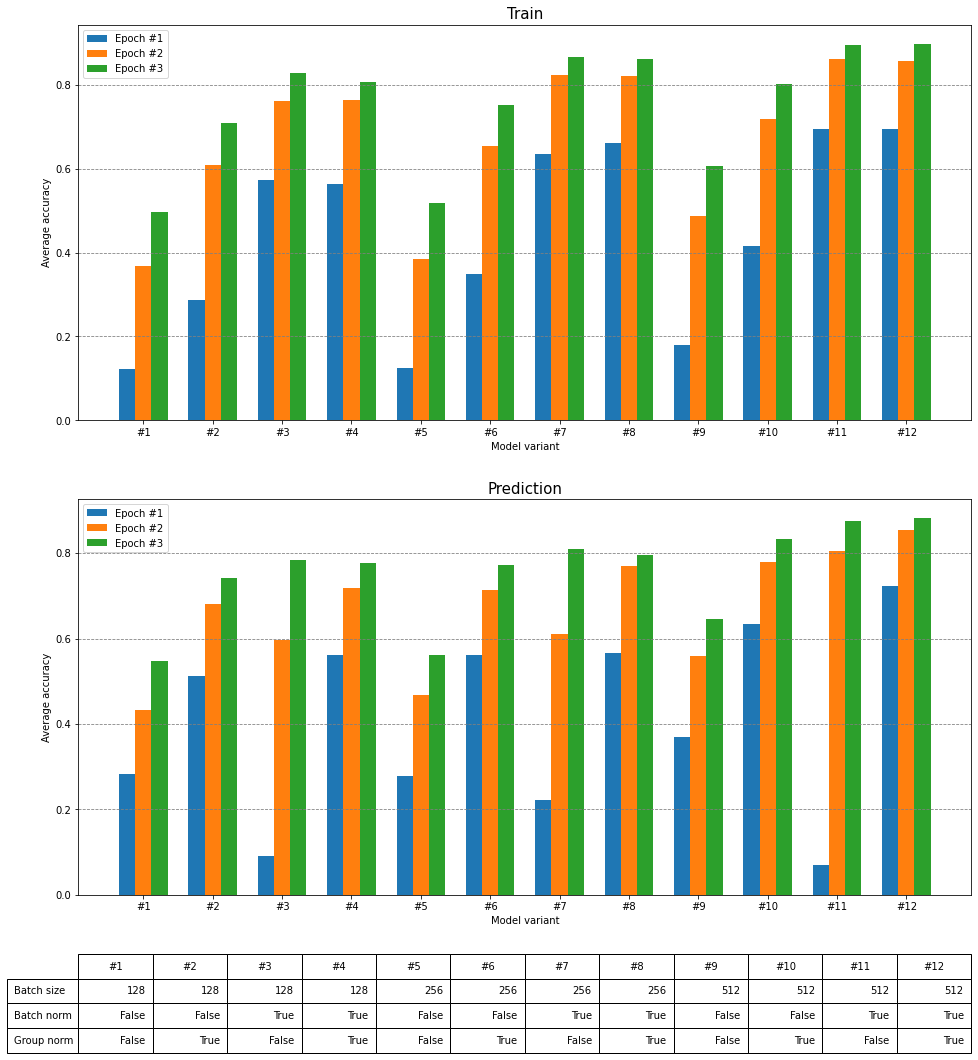

In [14]:
# Лучшие результаты
layers = 2
kernel_size = 12
channels = 8
padding = 2
stride = 1

epoch_count = 3

parameters = []
train_accuracy = []
test_accuracy = []

train_data = Pictures(train_images, train_labels, channels=1, CHW=True)
test_data = Pictures(test_images, test_labels, channels=1, CHW=True)

with tqdm(total=12 * epoch_count, position=0, leave=True) as pbar:
    for batch_size in [128, 256, 512]:
        for with_batch_norm in [False, True]:
            for with_group_norm in [False, True]:

                ######################################################
                # Инициализация

                net = ConvNet()
                net.add_linear_layer(2048, 1024, with_batch_norm=with_batch_norm)
                net.add_linear_layer(1024, 512, with_batch_norm=with_batch_norm)
                net.add_linear_layer(512, 256, with_batch_norm=with_batch_norm)
                for i in range(layers):
                    net.add_conv_layer(channels, kernel_size, stride=stride, padding=padding, with_batch_norm=with_batch_norm, with_group_norm=with_group_norm)
                optimizer = torch.optim.AdamW(net.parameters(), lr=0.0005)
                loss_criterion = nn.CrossEntropyLoss()

                ######################################################
                # Эпохи

                train_accuracy_epochs = []
                test_accuracy_epochs = []
                for epoch in range(epoch_count):

                    # Обучение
                    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                    train_accuracy_arr, _ = train(train_dataloader, net, loss_criterion, optimizer, limit=25)
                    train_accuracy_epochs.append(sum(train_accuracy_arr)/len(train_accuracy_arr))

                    # Предсказание
                    test_dataloader = DataLoader(test_data, batch_size=batch_size)
                    test_accuracy_arr, _, _, _ = test(test_dataloader, net, loss_criterion)
                    test_accuracy_epochs.append(sum(test_accuracy_arr)/len(test_accuracy_arr))

                    pbar.set_description(f"batch: {with_batch_norm} | group: {with_group_norm} | epoch: {epoch} ")
                    pbar.update(1)

                    del train_dataloader, test_dataloader
                    gc.collect()
                    torch.cuda.empty_cache()

                del net
                gc.collect()
                torch.cuda.empty_cache()

                ######################################################
                # Обновление статистики

                parameters.append([
                    ("Batch size", batch_size),
                    ("Batch norm", with_batch_norm),
                    ("Group norm", with_group_norm)
                ])
                train_accuracy.append(train_accuracy_epochs)
                test_accuracy.append(test_accuracy_epochs)

draw_statistics(parameters, train_accuracy, test_accuracy)

In [16]:
# Лучшие результаты
layers = 2
kernel_size = 12
channels = 8
padding = 2
stride = 1
batch_size = 512
with_batch_norm = True
with_group_norm = True

# Инициализация
best_conv_net = ConvNet()
best_conv_net.add_linear_layer(2048, 1024, with_batch_norm=with_batch_norm)
best_conv_net.add_linear_layer(1024, 512, with_batch_norm=with_batch_norm)
best_conv_net.add_linear_layer(512, 256, with_batch_norm=with_batch_norm)
best_conv_net.add_conv_layer(channels, kernel_size, stride=stride, padding=padding, with_batch_norm=with_batch_norm, with_group_norm=with_group_norm)
best_conv_net.add_conv_layer(channels, kernel_size, stride=stride, padding=padding, with_batch_norm=with_batch_norm, with_group_norm=with_group_norm)
optimizer = torch.optim.AdamW(best_conv_net.parameters(), lr=0.0005)
loss_criterion = nn.CrossEntropyLoss()

train_data = Pictures(train_images, train_labels, channels=1, CHW=True)
test_data = Pictures(test_images, test_labels, channels=1, CHW=True)

for epoch in range(10):
    print(f"--- Epoch #{epoch + 1} ---")
    # Обучение
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train(train_dataloader, best_conv_net, loss_criterion, optimizer, progress=True)
    # Предсказание
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    _, _, labels, pred = test(test_dataloader, best_conv_net, loss_criterion, progress=True)



--- Epoch #1 ---


Training   | Loss (cur): 0.39 | Loss (avg): 0.67 | Acc (cur): 87.7% | Acc (avg): 80.48% : 100%|██████████| 127/127 [02:24<00:00,  1.14s/it] 
Validation | Loss (cur): 0.31 | Loss (avg): 0.39 | Acc (cur): 91.0% | Acc (avg): 87.76% : 100%|██████████| 26/26 [00:32<00:00,  1.24s/it] 


--- Epoch #2 ---


Training   | Loss (cur): 0.32 | Loss (avg): 0.3 | Acc (cur): 89.14% | Acc (avg): 90.21% : 100%|██████████| 127/127 [02:24<00:00,  1.13s/it]
Validation | Loss (cur): 0.29 | Loss (avg): 0.31 | Acc (cur): 94.5% | Acc (avg): 90.08% : 100%|██████████| 26/26 [00:29<00:00,  1.15s/it] 


--- Epoch #3 ---


Training   | Loss (cur): 0.26 | Loss (avg): 0.23 | Acc (cur): 91.6% | Acc (avg): 92.18% : 100%|██████████| 127/127 [02:27<00:00,  1.16s/it] 
Validation | Loss (cur): 0.25 | Loss (avg): 0.3 | Acc (cur): 93.5% | Acc (avg): 90.39% : 100%|██████████| 26/26 [00:30<00:00,  1.19s/it]  


--- Epoch #4 ---


Training   | Loss (cur): 0.22 | Loss (avg): 0.19 | Acc (cur): 92.83% | Acc (avg): 93.45% : 100%|██████████| 127/127 [02:22<00:00,  1.12s/it]
Validation | Loss (cur): 0.25 | Loss (avg): 0.27 | Acc (cur): 95.5% | Acc (avg): 91.23% : 100%|██████████| 26/26 [00:27<00:00,  1.05s/it] 


--- Epoch #5 ---


Training   | Loss (cur): 0.18 | Loss (avg): 0.16 | Acc (cur): 92.83% | Acc (avg): 94.35% : 100%|██████████| 127/127 [02:23<00:00,  1.13s/it]
Validation | Loss (cur): 0.18 | Loss (avg): 0.27 | Acc (cur): 95.5% | Acc (avg): 91.38% : 100%|██████████| 26/26 [00:32<00:00,  1.24s/it] 


--- Epoch #6 ---


Training   | Loss (cur): 0.15 | Loss (avg): 0.13 | Acc (cur): 94.67% | Acc (avg): 95.36% : 100%|██████████| 127/127 [02:23<00:00,  1.13s/it]
Validation | Loss (cur): 0.23 | Loss (avg): 0.28 | Acc (cur): 93.5% | Acc (avg): 91.19% : 100%|██████████| 26/26 [00:29<00:00,  1.15s/it] 


--- Epoch #7 ---


Training   | Loss (cur): 0.12 | Loss (avg): 0.11 | Acc (cur): 95.7% | Acc (avg): 95.81% : 100%|██████████| 127/127 [02:24<00:00,  1.14s/it] 
Validation | Loss (cur): 0.16 | Loss (avg): 0.27 | Acc (cur): 95.5% | Acc (avg): 91.53% : 100%|██████████| 26/26 [00:27<00:00,  1.07s/it] 


--- Epoch #8 ---


Training   | Loss (cur): 0.09 | Loss (avg): 0.1 | Acc (cur): 96.93% | Acc (avg): 96.14% : 100%|██████████| 127/127 [02:22<00:00,  1.12s/it]
Validation | Loss (cur): 0.16 | Loss (avg): 0.29 | Acc (cur): 93.5% | Acc (avg): 91.43% : 100%|██████████| 26/26 [00:27<00:00,  1.06s/it] 


--- Epoch #9 ---


Training   | Loss (cur): 0.13 | Loss (avg): 0.09 | Acc (cur): 94.06% | Acc (avg): 96.31% : 100%|██████████| 127/127 [02:24<00:00,  1.14s/it]
Validation | Loss (cur): 0.29 | Loss (avg): 0.28 | Acc (cur): 92.0% | Acc (avg): 91.33% : 100%|██████████| 26/26 [00:32<00:00,  1.25s/it] 


--- Epoch #10 ---


Training   | Loss (cur): 0.11 | Loss (avg): 0.08 | Acc (cur): 95.29% | Acc (avg): 96.73% : 100%|██████████| 127/127 [02:23<00:00,  1.13s/it]
Validation | Loss (cur): 0.34 | Loss (avg): 0.3 | Acc (cur): 91.0% | Acc (avg): 91.29% : 100%|██████████| 26/26 [00:29<00:00,  1.15s/it]  


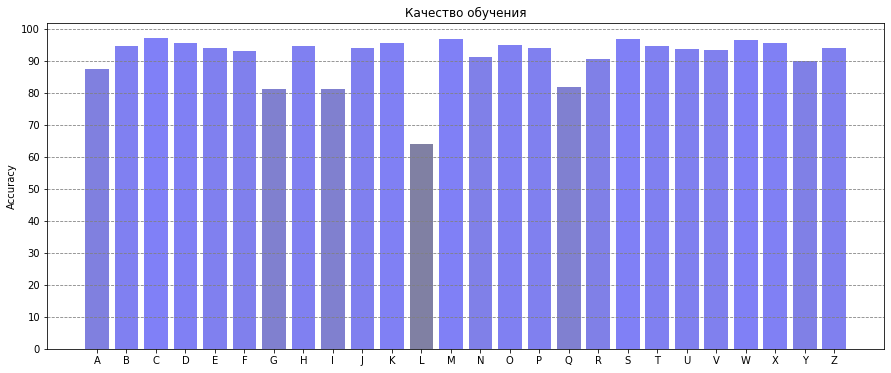

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, pred)
letters = [cm[i][i] for i in range(26)]

plt.figure(figsize=(15, 6))
plt.bar(range(26), [cm[i][i] / 500 * 100 for i in range(26)], color=[(0.5,0.5,letters[i]/500) for i in range(len(letters))])
plt.ylabel("Accuracy")
plt.yticks(range(0, 101, 10))
plt.xticks(range(26), [chr(i + 65) for i in range(26)])
plt.grid(axis='y', color = 'grey', linestyle = '--')
plt.title("Качество обучения")
plt.show()


### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

In [ ]:
# Обучил до 91% в задании №1.2 и №2.2

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

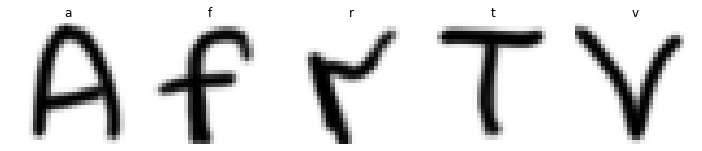

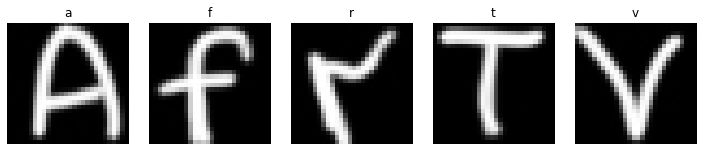

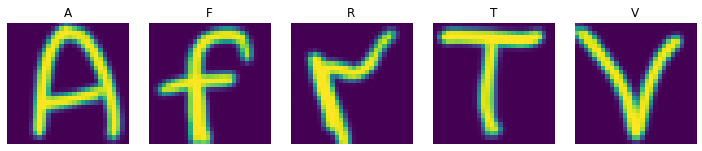

acc = 0.800000011920929
True labels: ['A', 'F', 'R', 'T', 'V']
Pred labels: ['A', 'F', 'Y', 'T', 'V']


In [52]:
# Написал черным маркером на A4, отсканировал сканером, обрезал и уменьшил в Adobe Photoshop

my_images = []
my_images.append(plt.imread("images/my_image_A.jpg"))
my_images.append(plt.imread("images/my_image_F.jpg"))
my_images.append(plt.imread("images/my_image_R.jpg"))
my_images.append(plt.imread("images/my_image_T.jpg"))
my_images.append(plt.imread("images/my_image_V.jpg"))
my_labels = ["a", "f", "r", "t", "v"]
draw_images([(my_labels[i], my_images[i]) for i in range(len(my_images))])

# Первод из черно-белой в бело-черную
my_images = [255 - image for image in my_images]
draw_images([(my_labels[i], my_images[i]) for i in range(len(my_images))])

my_dataset = Pictures(my_images, my_labels, channels=1, CHW=True, transposed=True)
my_dataloader = DataLoader(my_dataset, batch_size=5, shuffle=False)
draw_images([(my_dataset[i]["Label"], my_dataset[i]["Image"]) for i in range(len(my_images))])

with torch.no_grad():
    for i, batch in enumerate(my_dataloader, 0):
        images = batch["Image"].to(device)
        labels = batch["Label"].to(device)

        pred = best_dense_net(images)
        loss = nn.CrossEntropyLoss()(pred, labels)
        accuracy = (pred.argmax(1) == labels).float().mean()

        print(f"acc = {accuracy.item()}")
        print(f"True labels: {[chr(i + 65) for i in labels]}")
        print(f"Pred labels: {[chr(i + 65) for i in pred.argmax(1)]}")


**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).


In [18]:
from torchvision import models

train_data = Pictures(train_images, train_labels, channels=3, CHW=True)
test_data = Pictures(test_images, test_labels, channels=3, CHW=True)

resnet = models.resnet34(pretrained=True)
batch_size = 256
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=0.0005)

torch.cuda.empty_cache()
gc.collect()

for epoch in range(10):
    print(f"--- Epoch {epoch + 1} ---")
    train(DataLoader(train_data, batch_size=batch_size, shuffle=True), resnet, loss_criteria=loss_criterion, optimizer=optimizer, progress=True)
    _, _, labels, pred = test(DataLoader(test_data, batch_size=batch_size), resnet, loss_criteria=loss_criterion, progress=True)


--- Epoch 1 ---


Training   | Loss (cur): 0.13 | Loss (avg): 0.59 | Acc (cur): 95.69% | Acc (avg): 85.86% : 100%|██████████| 254/254 [03:30<00:00,  1.21it/s]
Validation | Loss (cur): 0.12 | Loss (avg): 0.22 | Acc (cur): 97.0% | Acc (avg): 92.71% : 100%|██████████| 51/51 [00:35<00:00,  1.45it/s] 


--- Epoch 2 ---


Training   | Loss (cur): 0.19 | Loss (avg): 0.18 | Acc (cur): 93.53% | Acc (avg): 93.82% : 100%|██████████| 254/254 [03:30<00:00,  1.21it/s]
Validation | Loss (cur): 0.11 | Loss (avg): 0.17 | Acc (cur): 97.0% | Acc (avg): 94.44% : 100%|██████████| 51/51 [00:36<00:00,  1.39it/s] 


--- Epoch 3 ---


Training   | Loss (cur): 0.18 | Loss (avg): 0.15 | Acc (cur): 94.4% | Acc (avg): 94.59% : 100%|██████████| 254/254 [03:35<00:00,  1.18it/s] 
Validation | Loss (cur): 0.08 | Loss (avg): 0.18 | Acc (cur): 98.5% | Acc (avg): 94.1% : 100%|██████████| 51/51 [00:36<00:00,  1.38it/s]  


--- Epoch 4 ---


Training   | Loss (cur): 0.12 | Loss (avg): 0.13 | Acc (cur): 94.4% | Acc (avg): 95.28% : 100%|██████████| 254/254 [03:35<00:00,  1.18it/s] 
Validation | Loss (cur): 0.05 | Loss (avg): 0.18 | Acc (cur): 98.0% | Acc (avg): 94.05% : 100%|██████████| 51/51 [00:37<00:00,  1.38it/s] 


--- Epoch 5 ---


Training   | Loss (cur): 0.17 | Loss (avg): 0.12 | Acc (cur): 92.24% | Acc (avg): 95.51% : 100%|██████████| 254/254 [03:35<00:00,  1.18it/s]
Validation | Loss (cur): 0.17 | Loss (avg): 0.19 | Acc (cur): 96.0% | Acc (avg): 94.05% : 100%|██████████| 51/51 [00:36<00:00,  1.40it/s] 


--- Epoch 6 ---


Training   | Loss (cur): 0.11 | Loss (avg): 0.11 | Acc (cur): 96.55% | Acc (avg): 95.94% : 100%|██████████| 254/254 [03:35<00:00,  1.18it/s]
Validation | Loss (cur): 0.07 | Loss (avg): 0.18 | Acc (cur): 98.5% | Acc (avg): 94.29% : 100%|██████████| 51/51 [00:36<00:00,  1.38it/s] 


--- Epoch 7 ---


Training   | Loss (cur): 0.1 | Loss (avg): 0.1 | Acc (cur): 96.55% | Acc (avg): 96.14% : 100%|██████████| 254/254 [03:38<00:00,  1.17it/s] 
Validation | Loss (cur): 0.04 | Loss (avg): 0.19 | Acc (cur): 99.5% | Acc (avg): 94.19% : 100%|██████████| 51/51 [00:37<00:00,  1.37it/s] 


--- Epoch 8 ---


Training   | Loss (cur): 0.09 | Loss (avg): 0.09 | Acc (cur): 96.55% | Acc (avg): 96.48% : 100%|██████████| 254/254 [03:35<00:00,  1.18it/s]
Validation | Loss (cur): 0.07 | Loss (avg): 0.2 | Acc (cur): 99.0% | Acc (avg): 93.85% : 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]  


--- Epoch 9 ---


Training   | Loss (cur): 0.14 | Loss (avg): 0.09 | Acc (cur): 94.4% | Acc (avg): 96.45% : 100%|██████████| 254/254 [03:35<00:00,  1.18it/s] 
Validation | Loss (cur): 0.18 | Loss (avg): 0.21 | Acc (cur): 96.5% | Acc (avg): 93.64% : 100%|██████████| 51/51 [00:36<00:00,  1.38it/s] 


--- Epoch 10 ---


Training   | Loss (cur): 0.07 | Loss (avg): 0.09 | Acc (cur): 97.84% | Acc (avg): 96.51% : 100%|██████████| 254/254 [03:35<00:00,  1.18it/s]
Validation | Loss (cur): 0.37 | Loss (avg): 0.22 | Acc (cur): 93.0% | Acc (avg): 93.35% : 100%|██████████| 51/51 [00:36<00:00,  1.38it/s] 


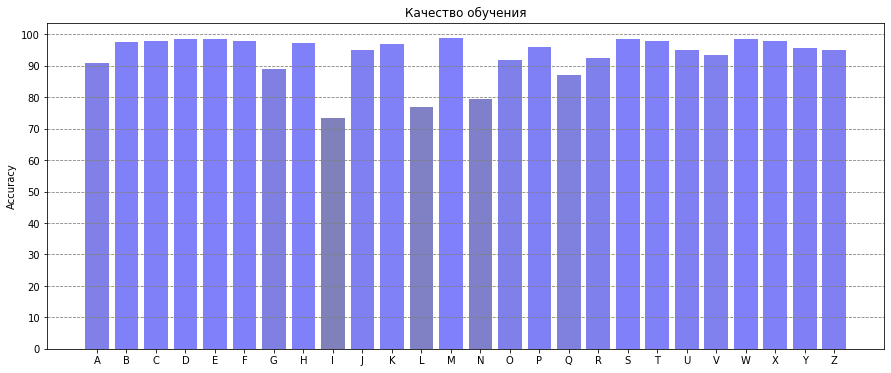

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, pred)
letters = [cm[i][i] for i in range(26)]

plt.figure(figsize=(15, 6))
plt.bar(range(26), [cm[i][i] / 500 * 100 for i in range(26)], color=[(0.5,0.5,letters[i]/500) for i in range(len(letters))])
plt.ylabel("Accuracy")
plt.yticks(range(0, 101, 10))
plt.xticks(range(26), [chr(i + 65) for i in range(26)])
plt.grid(axis='y', color = 'grey', linestyle = '--')
plt.title("Качество обучения")
plt.show()


**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.


In [ ]:
!start tensorboard --logdir=runs

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Инициализация
net = Net(128)
for i in range(2):
    net.add_dense_layer()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0005)
loss_criterion = nn.CrossEntropyLoss()

train_data = Pictures(train_images, train_labels, channels=1, CHW=True)
test_data = Pictures(test_images, test_labels, channels=1, CHW=True)

epochs = 10
for epoch in range(epochs):
    print(f"--- Epoch #{epoch + 1} ---")
    # Обучение
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    train_accuracy_arr, train_loss_arr = train(train_dataloader, net, loss_criterion, optimizer, progress=True, limit=25)
    # Предсказание
    test_dataloader = DataLoader(test_data, batch_size=256)
    test_accuracy_arr, test_loss_arr, _, _ = test(test_dataloader, net, loss_criterion, progress=True, limit=25)

    writer.add_scalar('Loss/train', sum(train_loss_arr)/len(train_loss_arr), epoch)
    writer.add_scalar('Loss/test', sum(test_loss_arr)/len(test_loss_arr), epoch)
    writer.add_scalar('Accuracy/train', sum(train_accuracy_arr)/len(train_accuracy_arr), epoch)
    writer.add_scalar('Accuracy/test', sum(test_accuracy_arr)/len(test_accuracy_arr), epoch)


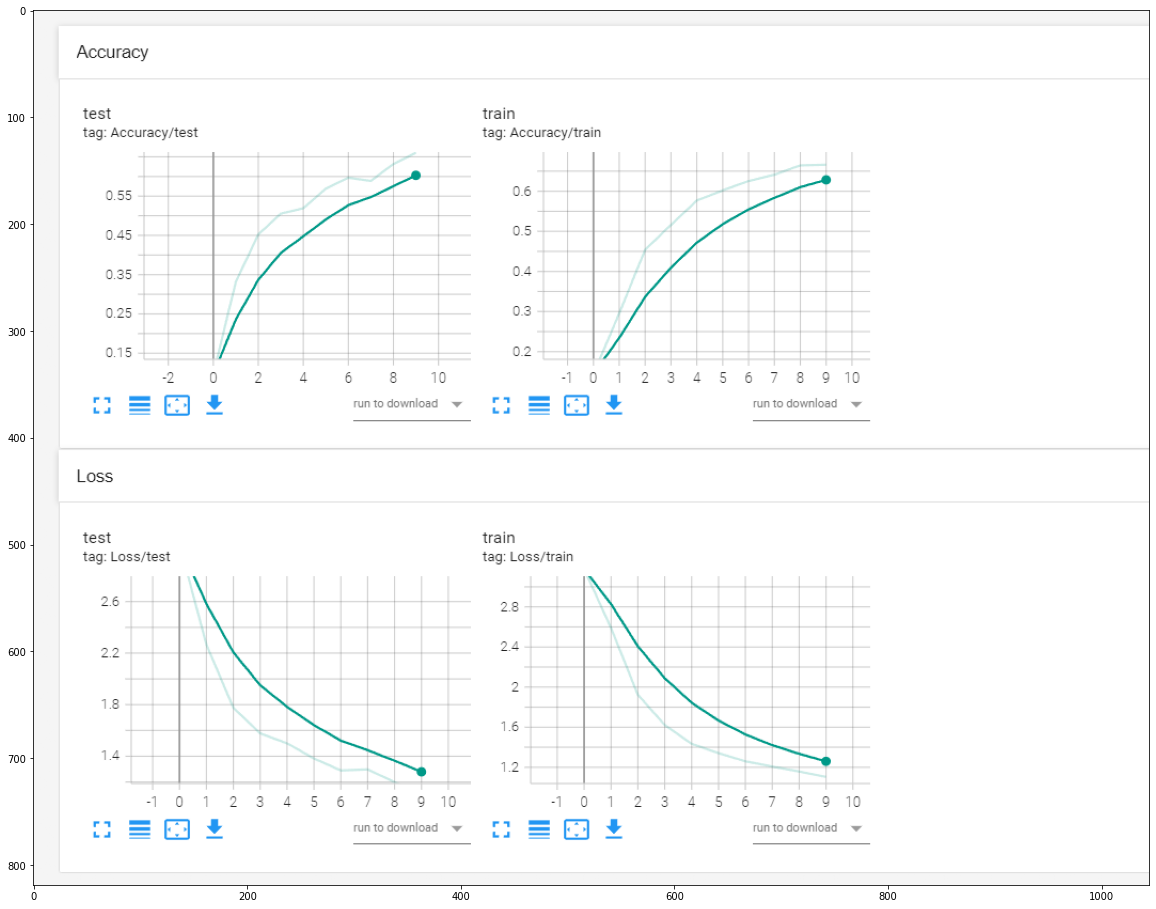

In [21]:
plt.figure(figsize=(20, 20))
plt.imshow(plt.imread("images/Tensorboard.png"))
plt.show()

# Не получилось загзузить SVG картинки в notebook ;(